In [1]:
import math, json, os, sys

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import optimizers
from keras import backend as K
import tensorflow as tf
import cv2


Using TensorFlow backend.


# Helper Functions

In [2]:
def create_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [3]:
def plot(history):

    with open('output/file.json', 'w') as f:
        json.dump(str(history.history), f)

    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('output/history_acc.png')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('output/history_loss.png')
    plt.show()


# Creating the Model

In [4]:
def create_model(dim_x, dim_y, lr):
    input_shape = (dim_x,dim_y,3)
   
    model = ResNet50(include_top=True,
                    weights= None,
                    input_tensor=None,
                    input_shape=input_shape,
                    pooling='avg',
                    classes=2)

    model.compile(optimizer = Adam(lr) ,
                loss = "categorical_crossentropy", 
                metrics=["accuracy"])
    
    model.summary()
    return model

# Training

Found 361 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_________

Epoch 1/2
45/45 [==============================] - 190s 4s/step - loss: 0.6957 - accuracy: 0.5666 - val_loss: 1.8959 - val_accuracy: 0.4896

Epoch 00001: val_loss improved from inf to 1.89588, saving model to output/resnet50_224_best.h5
Epoch 2/2
45/45 [==============================] - 155s 3s/step - loss: 0.6612 - accuracy: 0.5949 - val_loss: 0.6718 - val_accuracy: 0.5652

Epoch 00002: val_loss improved from 1.89588 to 0.67176, saving model to output/resnet50_224_best.h5
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


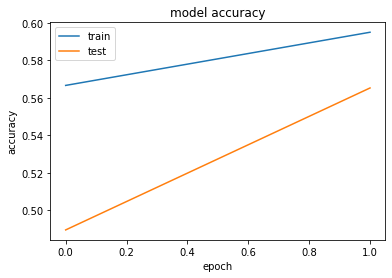

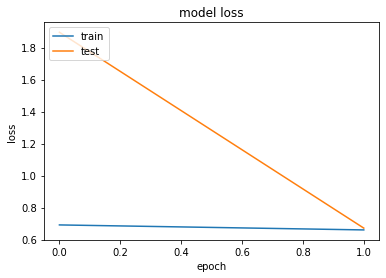

In [5]:
data_dir = '../data_cd'
batch_size = 8
epochs = 2


train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'valid')

create_folder('output')

dim_x = 224
dim_y = 224
lr = 1e-5
patience = 10

num_train_samples = sum([len(files) for r, d, files in os.walk(train_dir)])
num_valid_samples = sum([len(files) for r, d, files in os.walk(val_dir)])

num_train_steps = math.floor(num_train_samples/batch_size)
num_valid_steps = math.floor(num_valid_samples/batch_size)

train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batches = train_gen.flow_from_directory(train_dir,target_size=(dim_x, dim_y),batch_size=batch_size, class_mode='categorical')
val_batches = val_gen.flow_from_directory(val_dir, target_size=(dim_x, dim_y) , batch_size=batch_size, class_mode='categorical')

#model = create_model(dim_x, dim_y, lr) # add parameters

model = create_model(dim_x, dim_y, lr)

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                        patience=5, 
                                        verbose=1, 
                                        factor=0.5, 
                                        min_lr=lr)

early_stopping = EarlyStopping(patience=patience)
checkpointer = ModelCheckpoint('output/resnet50_224_best.h5', verbose=1, save_best_only=True)

classes = list(iter(train_batches.class_indices))

#for c in train_batches.class_indices:
#    print("Class indices: " + str(c))
#    classes[train_batches.class_indices[c]] = c
#model.classes = classes

history = model.fit_generator(train_batches, steps_per_epoch=num_train_steps, epochs=epochs, callbacks=[early_stopping, checkpointer], validation_data=val_batches, validation_steps=num_valid_steps)

model.load_weights("output/resnet50_224_best.h5")

model.save('output/resnet50_224.h5')

plot(history)


# Testing

Found 40 images belonging to 1 classes.
40/40 [==============================] - 4s 111ms/step
Predictions:  [[0.6021693  0.39783075]
 [0.6226711  0.37732884]
 [0.6277229  0.37227705]
 [0.54799026 0.45200974]
 [0.6556221  0.34437782]
 [0.660748   0.33925205]
 [0.62151617 0.37848383]
 [0.4951373  0.5048627 ]
 [0.5263084  0.47369158]
 [0.6586982  0.3413018 ]
 [0.5311969  0.46880308]
 [0.5920821  0.4079179 ]
 [0.45290014 0.5470999 ]
 [0.67888224 0.32111773]
 [0.54459494 0.4554051 ]
 [0.54936534 0.4506347 ]
 [0.7037467  0.29625338]
 [0.56146187 0.43853813]
 [0.6399163  0.3600837 ]
 [0.53044975 0.46955016]
 [0.5429466  0.45705342]
 [0.6340994  0.36590058]
 [0.6175369  0.38246313]
 [0.58737034 0.4126296 ]
 [0.5578554  0.4421445 ]
 [0.5398757  0.46012437]
 [0.60595435 0.39404565]
 [0.6707747  0.3292253 ]
 [0.60719615 0.39280385]
 [0.43583646 0.56416357]
 [0.70678705 0.29321295]
 [0.60341096 0.3965891 ]
 [0.59604216 0.40395778]
 [0.6363363  0.36366364]
 [0.5502645  0.44973552]
 [0.71599334 0.2

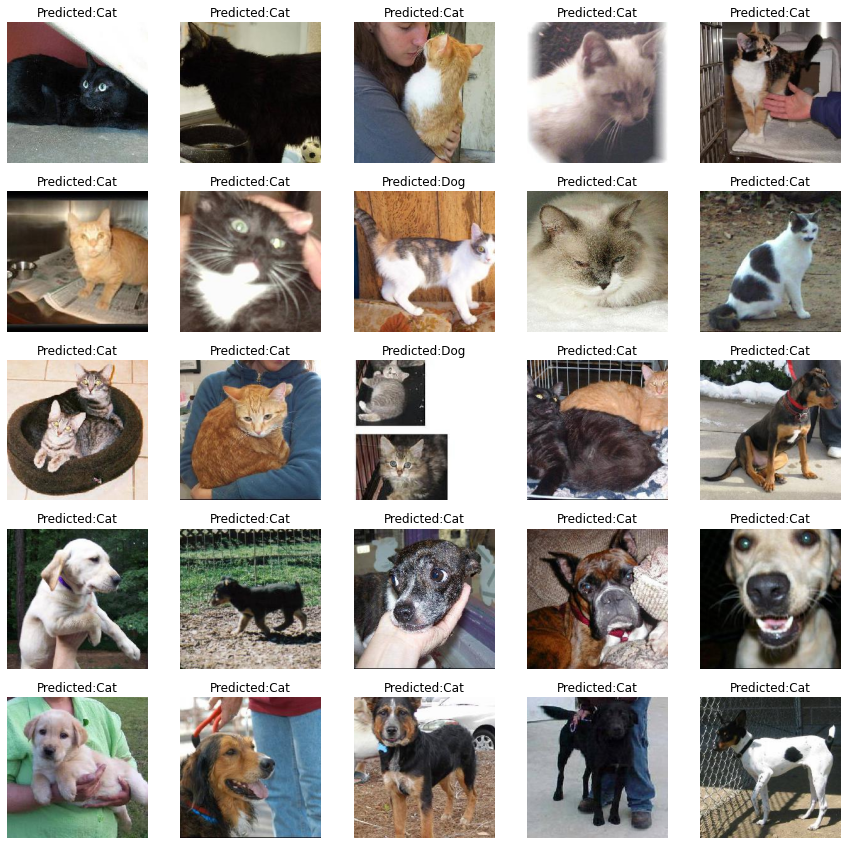

In [7]:
test_dir = os.path.join(data_dir, 'test')
batch_size_test = 1
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_batches = test_gen.flow_from_directory(directory = test_dir, target_size = (dim_x, dim_y),
    batch_size = batch_size_test,
    class_mode = None,
    shuffle = False,
    seed = 123
)

test_batches.reset()

pred = model.predict_generator(test_batches, steps = len(test_batches), verbose = 1)

print("Predictions: " , str(pred))

predicted_class_indices = np.argmax(pred, axis = 1)

print("Predicted class indices: ", str(predicted_class_indices))

f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(os.path.join(test_dir, test_batches.filenames[i]))
    
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    # a if condition else b
    predicted_class = "Dog" if predicted_class_indices[i] else "Cat"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))   

plt.savefig('predictions.png')

plt.show()